# About the Data

The data used for this project represent the Unemployment Rate in USA from January 2000 to June 2018. This represents the monthly data collected by U.S. Bureau of Labor Statistics and the series comes from the 'Current Population Survey (Household Survey)'.

The data is available at below sites. 

https://fred.stlouisfed.org/categories/32447?t=bls%3Bindustry&ob=pv&od=desc

https://fred.stlouisfed.org/series/LNU04032232   - Manufacturing Industry Data

https://fred.stlouisfed.org/series/LNU04032231   - Construction Industry Data

https://fred.stlouisfed.org/series/LNU04032238   - Financial Industry Data

https://fred.stlouisfed.org/series/LNU04032236   - Transportation Industry Data

https://fred.stlouisfed.org/series/LNU04032239  - Business Industry Data


The dataset contains 5 time series representing the unemployment rate of various industries between 2000 and 2018. 

Motivation for the project came from a general interest to know how the things are going to change in near future. This notebook focuses specifically on one area, but the principles could be extended to other areas as well.

Let's start by importing the required libraries.

In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

import warnings
import time
import itertools
import datetime

%matplotlib inline

 Let's start loading the dataset separately for each industry.

In [604]:
df_m = pd.read_csv('Unemployment Rate-Manufacturing.csv')
df_c = pd.read_csv('Unemployment Rate Construction.csv')
df_f = pd.read_csv('Unemployment Rate Financial .csv')
df_t = pd.read_csv('Unemployment Rate Transportation.csv')
df_pb = pd.read_csv('Unemployment Rate Professional and Business Services.csv')

In [4]:
df_m.shape

(222, 2)

The dataset for Manufacturing industry have 222 observations. As mentioned earlier, this dataset has data from January 2000 to June 2018. So when we calculate the gap between these two time periods, it is 222 months of data. So we have 222 observations. And the same goes for other industries as well.

In [4]:
df_c.shape

(222, 2)

In [84]:
df_pb.shape

(222, 2)

Let's have a look at the first 5 rows of the manufacturing industry data

In [8]:
df_m.head()

,DATE,LNU04032232
0,2000-01-01,3.6
1,2000-02-01,3.4
2,2000-03-01,3.6
3,2000-04-01,3.7
4,2000-05-01,3.4


We need to give a meaningful name to the column which represent the unemployment rate for manufacturing industry.

In [609]:
df_m.rename(columns= {'LNU04032232':'Manufacturing'}, inplace=True)

In [8]:
df_m.tail()

,DATE,Manufacturing
217,2018-02-01,3.6
218,2018-03-01,3.3
219,2018-04-01,3.3
220,2018-05-01,3.4
221,2018-06-01,3.1


In [9]:
df_c.head()

,DATE,LNU04032231
0,2000-01-01,9.7
1,2000-02-01,10.6
2,2000-03-01,8.7
3,2000-04-01,5.8
4,2000-05-01,5.0


Similarly, we rename the column for other industries as well.

In [605]:
df_c.rename(columns= {'LNU04032231':'Construction'}, inplace=True)

In [11]:
df_c.tail()

,DATE,Construction
217,2018-02-01,7.8
218,2018-03-01,7.4
219,2018-04-01,6.5
220,2018-05-01,4.4
221,2018-06-01,4.7


In [12]:
df_pb.head()

,DATE,LNU04032239
0,2000-01-01,5.7
1,2000-02-01,5.2
2,2000-03-01,5.4
3,2000-04-01,4.5
4,2000-05-01,4.7


In [606]:
df_f.rename(columns= {'LNU04032238':'Finance'}, inplace=True)
df_t.rename(columns= {'LNU04032236':'Transport'}, inplace=True)
df_pb.rename(columns= {'LNU04032239':'Business_Services'}, inplace=True)

For visualization purpose, we need to combine all the industries and make it one dataframe

In [611]:
from functools import reduce
dfs = [df_m, df_c, df_f, df_t, df_pb]
unemp_df = reduce(lambda left,right: pd.merge(left,right,on='DATE'), dfs)

In [612]:
unemp_df.shape

(222, 6)

In [613]:
unemp_df.head()

,DATE,Manufacturing,Construction,Finance,Transport,Business_Services
0,2000-01-01,3.6,9.7,2.7,4.3,5.7
1,2000-02-01,3.4,10.6,2.8,4.0,5.2
2,2000-03-01,3.6,8.7,2.6,3.5,5.4
3,2000-04-01,3.7,5.8,2.3,3.4,4.5
4,2000-05-01,3.4,5.0,2.2,3.4,4.7


Let's check if there is any missing value in our dataframe

In [8]:
unemp_df.isnull().sum()

DATE                 0
Manufacturing        0
Construction         0
Finance              0
Transport            0
Business_Services    0
dtype: int64

As we see, there is no missing value in our dataframe. Let's check the datatypes for the columns.

In [9]:
unemp_df.dtypes

DATE                  object
Manufacturing        float64
Construction         float64
Finance              float64
Transport            float64
Business_Services    float64
dtype: object

The date column has object datatype, we need to change this to datetime and also we need to set that datetime column as index for time series analysis.

In [655]:
unemp_df['DATE'] = pd.to_datetime(unemp_df.DATE)
unemp_df = unemp_df.set_index('DATE')

Now lets see how our data looks.

In [640]:
unemp_df.head()

,DATE,Manufacturing,Construction,Finance,Transport,Business_Services
0,2000-01-01,3.6,9.7,2.7,4.3,5.7
1,2000-02-01,3.4,10.6,2.8,4.0,5.2
2,2000-03-01,3.6,8.7,2.6,3.5,5.4
3,2000-04-01,3.7,5.8,2.3,3.4,4.5
4,2000-05-01,3.4,5.0,2.2,3.4,4.7


lets have a look at the summary statistics

In [20]:
unemp_df.describe()

,Manufacturing,Construction,Finance,Transport,Business_Services
count,222.000000,222.000000,222.000000,222.000000,222.000000
mean,5.997297,10.021171,3.802252,5.326126,7.041892
std,2.410571,4.859059,1.482551,1.804404,2.057434
min,2.600000,4.400000,1.500000,2.300000,3.300000
25%,4.225000,6.200000,2.700000,4.000000,5.400000
50%,5.300000,8.550000,3.350000,4.750000,6.500000
75%,6.900000,12.275000,4.500000,6.475000,8.400000
max,13.000000,27.100000,7.700000,11.300000,12.400000


# Visualization

In [22]:
unemp_df.columns

Index(['Manufacturing', 'Construction', 'Finance', 'Transport',
       'Business_Services'],
      dtype='object')

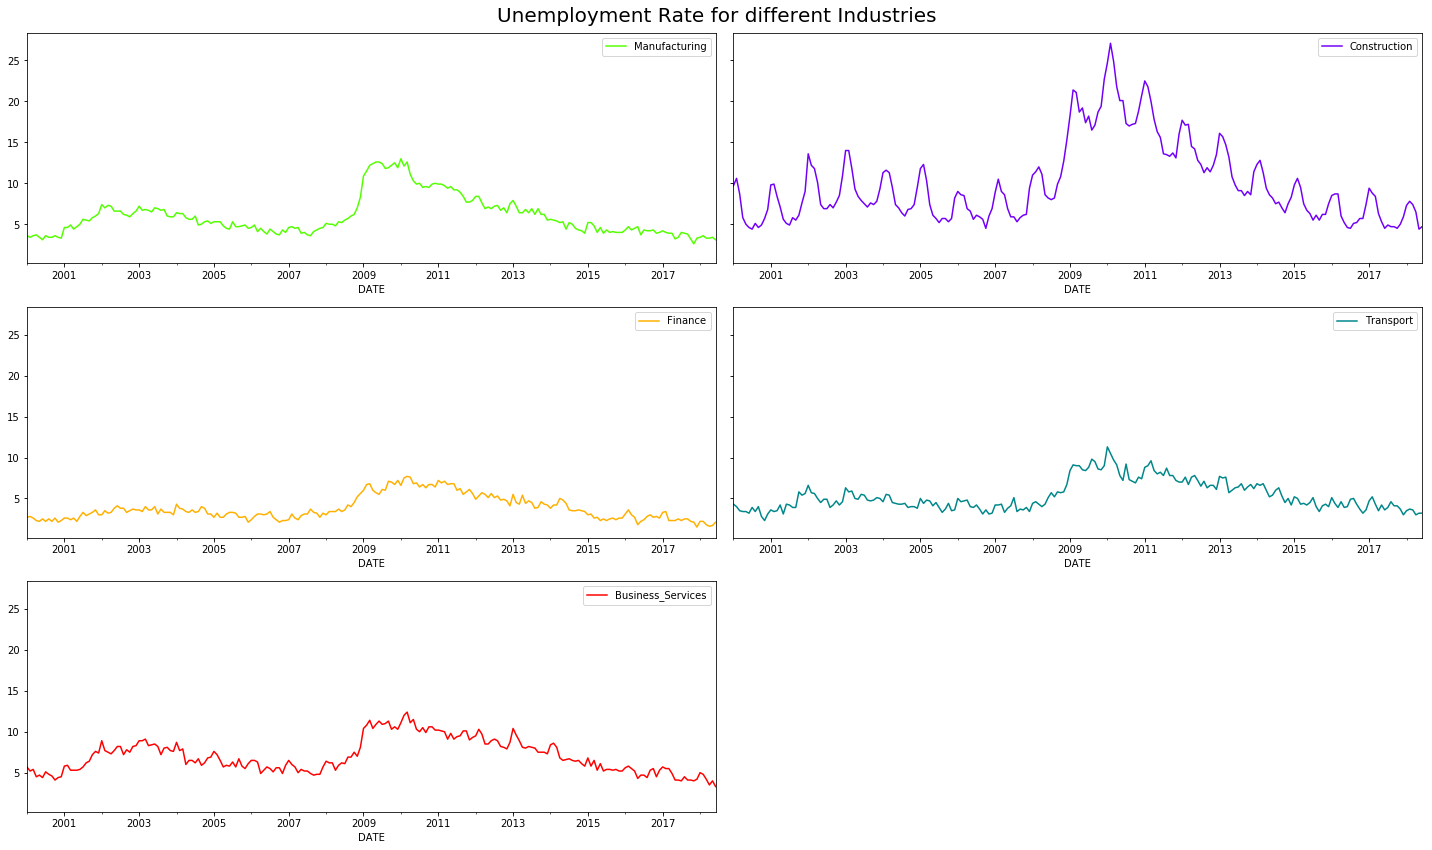

In [657]:
unemp_df.plot(subplots=True, sharex=False, sharey = True, layout = (3,2),figsize = (20,12) , colormap='prism_r')
plt.suptitle('Unemployment Rate for different Industries', fontsize=20)
plt.xticks(rotation=90)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

When plotting the Finance,  Manufacturing, Transport, Construction and Business time series DataFrame, we observed increase in unemployment rates during 2008.  

# Plot monthly and yearly unemployment to find Seasonality and Trend

In [658]:
#monthly averages of unemployment rates in each sector
monthly_unemp = unemp_df.groupby(unemp_df.index.month).mean()
monthly_unemp

,Manufacturing,Construction,Finance,Transport,Business_Services
DATE,,,,,
1,6.400000,12.926316,3.805263,5.921053,7.794737
2,6.315789,13.310526,4.000000,5.831579,7.610526
3,6.210526,12.368421,3.852632,5.657895,7.478947
4,5.978947,10.394737,3.805263,5.273684,6.589474
5,5.905263,9.094737,3.657895,5.015789,6.778947
6,5.694737,8.468421,3.847368,5.147368,6.715789
7,6.172222,8.233333,3.766667,5.566667,6.933333
8,5.866667,8.194444,3.855556,5.311111,6.855556
9,5.855556,8.272222,3.750000,5.044444,6.927778


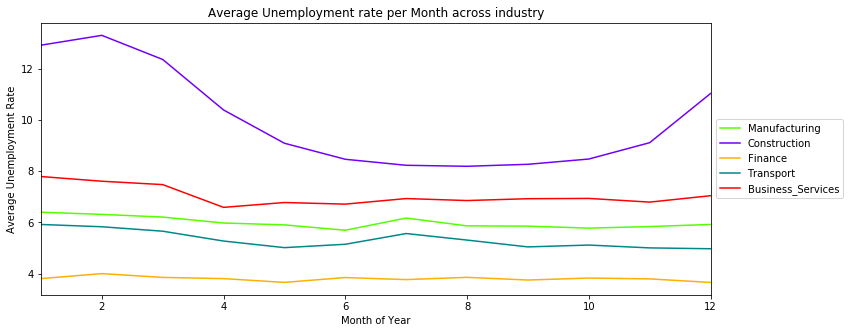

In [659]:
# plot the monthly averages of unemployment rates in each sector
ax = monthly_unemp.plot(figsize= (12,5),colormap= 'prism_r')
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
ax.set_xlabel('Month of Year')
ax.set_ylabel('Average Unemployment Rate')
ax.set_title('Average Unemployment rate per Month across industry')
plt.show()

construction shows significant increase in Months 1, 2, 3 and 12 (winter month)

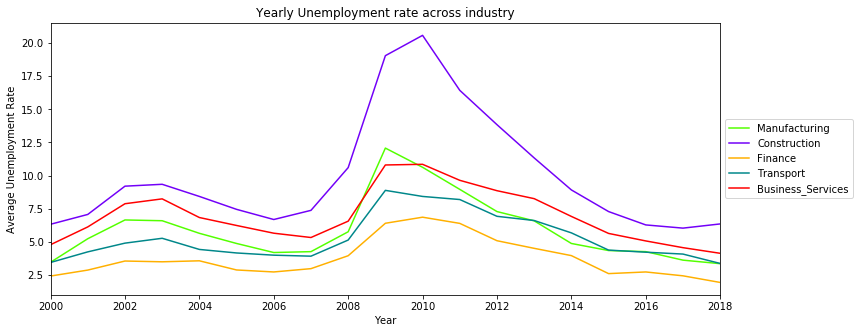

In [660]:
yearly_unemp = unemp_df.groupby(unemp_df.index.year).mean()
ax = yearly_unemp.plot(figsize= (12,5),colormap= 'prism_r')
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
ax.set_xlabel('Year')
ax.set_ylabel('Average Unemployment Rate')
ax.set_title('Yearly Unemployment rate across industry')
plt.show()

We observed increase in unemployment rates during 2008, with Construction sector being affected the most.

# Decompose time series data


   We can use statsmodels to perform a decomposition of this time series. The decomposition of time series is a statistical task that breaks a time series into several components, each representing one of the underlying categories of patterns. With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

   We use an additive model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time . A multiplicative model is more appropriate when we are increasing (or decreasing) at a non-linear rate . By default it uses an additive model.

In [661]:
# Initialize dictionary
jobs_seasonal = {}
jobs_trend = {}
jobs_residual = {}

# Run time series decomposition on each time series of the DataFrame
for ts in unemp_df.columns:
    decomp = seasonal_decompose(unemp_df[ts])
    jobs_seasonal[ts] = decomp.seasonal
    jobs_trend[ts] = decomp.trend
    jobs_residual[ts] = decomp.resid

In [662]:
seasonality_df = pd.DataFrame(jobs_seasonal)
seasonality_df.head()

,Business_Services,Construction,Finance,Manufacturing,Transport
DATE,,,,,
2000-01-01,0.808752,3.078317,0.020244,0.511938,0.675132
2000-02-01,0.647478,3.425130,0.231764,0.415615,0.578073
2000-03-01,0.525909,2.508219,0.101617,0.301644,0.416063
2000-04-01,-0.372866,0.526601,0.078333,0.036938,0.024396
2000-05-01,-0.201297,-0.753056,-0.085393,-0.030709,-0.282221


 visualize the seasonality in these time series. 

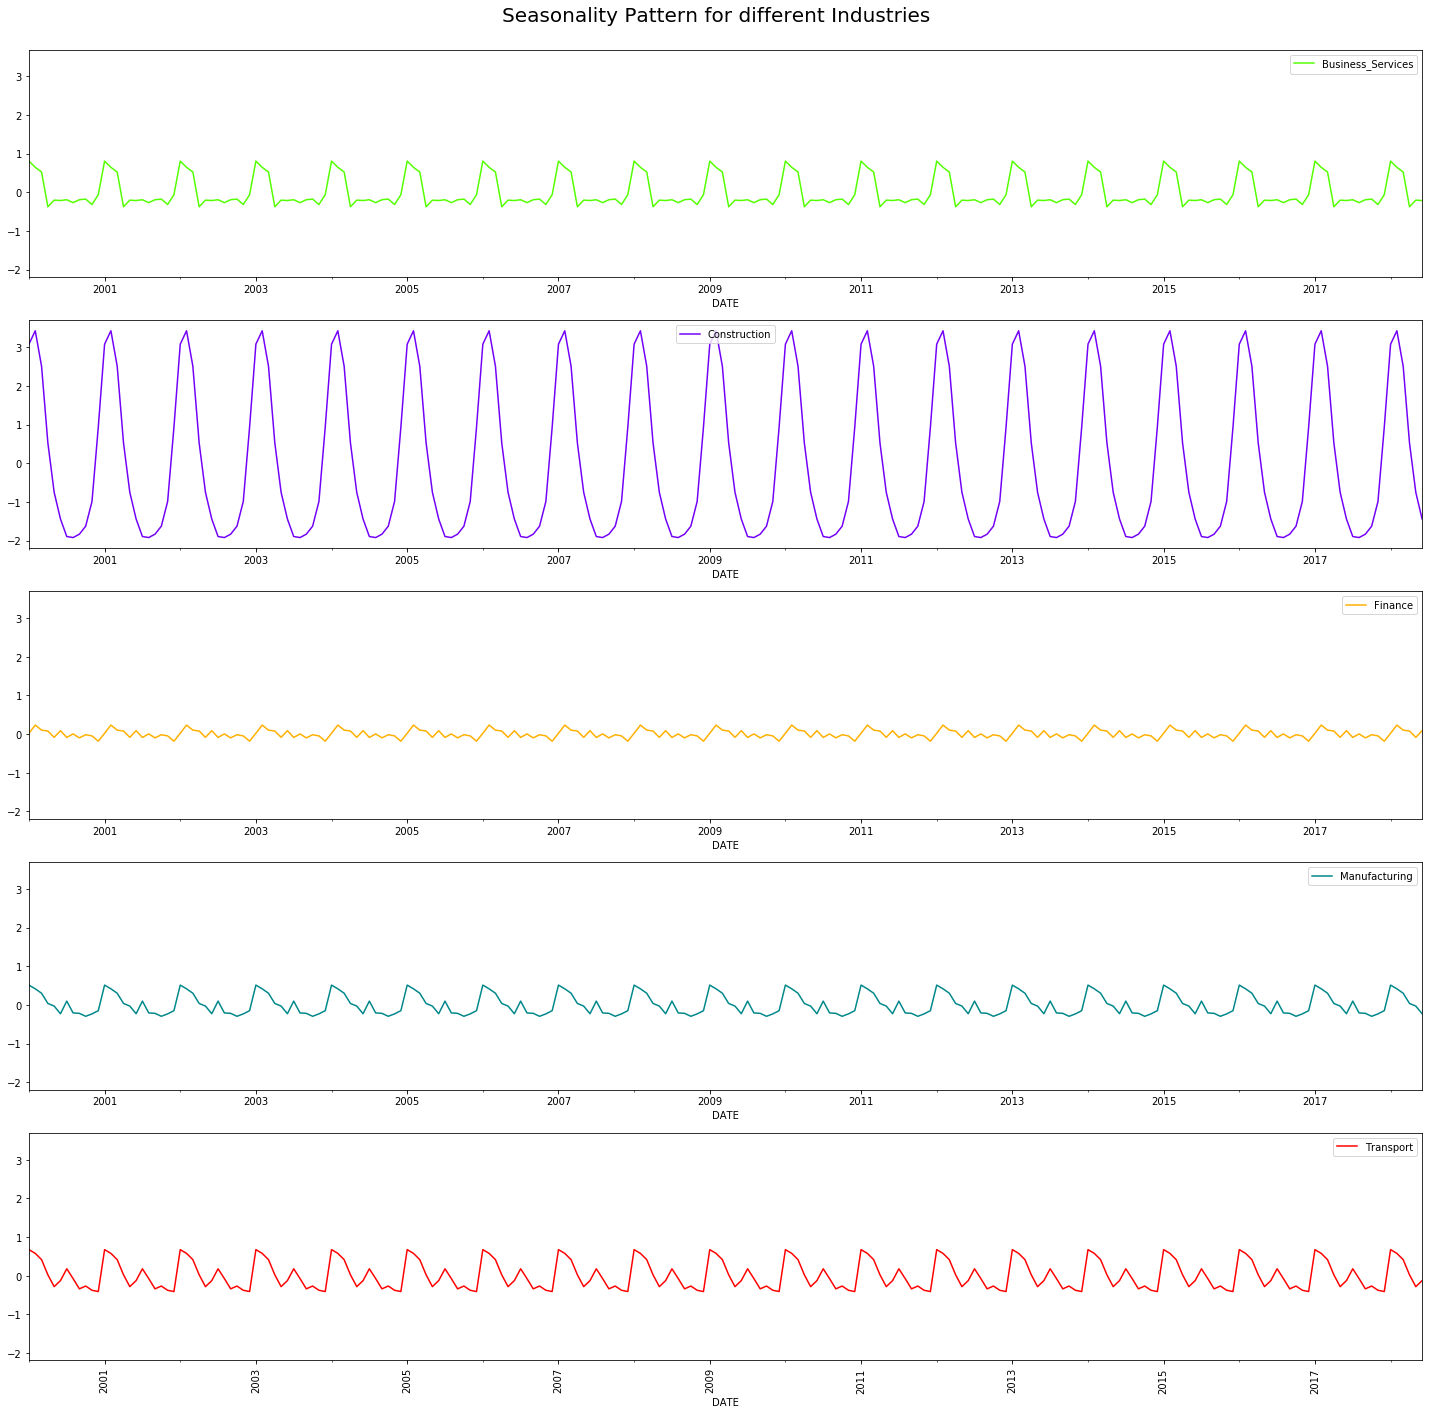

In [664]:
seasonality_df.plot(subplots=True, sharex=False, sharey = True, layout = (5,1),figsize = (20,20) , colormap='prism_r')
plt.suptitle('Seasonality Pattern for different Industries', fontsize=20)
plt.xticks(rotation=90)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

Each time series in the DataFrame have very different seasonality patterns!

Lets analyse the manufacturing Industry

In [103]:
df_m['DATE'] = pd.to_datetime(df_m.DATE)
df_m = df_m.set_index('DATE')
df_m.head()

,Manufacturing
DATE,
2000-01-01,3.6
2000-02-01,3.4
2000-03-01,3.6
2000-04-01,3.7
2000-05-01,3.4


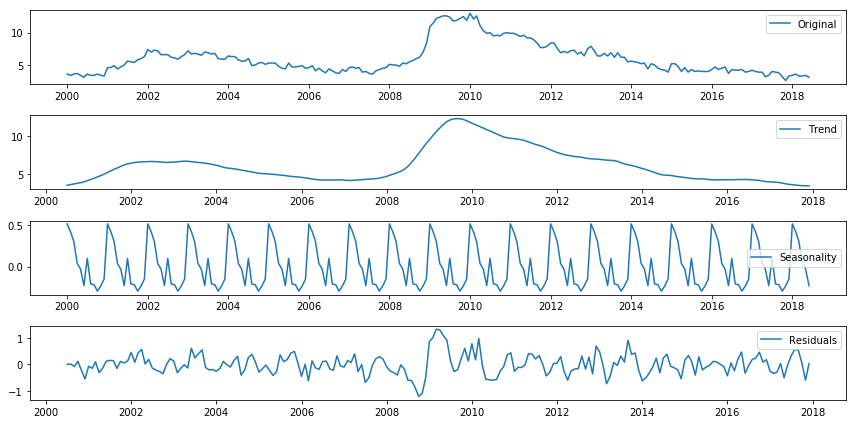

In [105]:
decomposition = seasonal_decompose(df_m.Manufacturing)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(df_m.Manufacturing, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Augmented Dickey-Fuller (ADF) test
The Augmented Dickey-Fuller test is used to test for a unit root in a time series sample. The presence of the unit root in time series make it non-stationary (has some time-dependent structure).

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root.

Interpretation of ADF Test result:

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [13]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics we’ll take the average/variance of the last year, i.e. last 12 months. 
    rolmean = timeseries.rolling(window=12,center=False).mean()

    rolstd = timeseries.rolling(window=12,center=False).std()


    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Data')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    # dftest[0] is test statistics value, 1 is p-value etc..
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

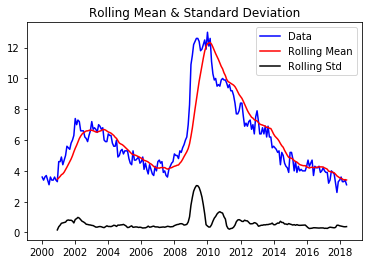

Results of Dickey-Fuller Test:
Test Statistic                  -2.547708
p-value                          0.104294
#Lags Used                      12.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


In [8]:
test_stationarity(df_m.Manufacturing)

it confirms that the data is not stationary.

# First let's make the data stationary
So try taking first order difference.

In [666]:
man_diff = df_m.Manufacturing - df_m.Manufacturing.shift()

In [107]:
man_diff.head()

DATE
2000-01-01    NaN
2000-02-01   -0.2
2000-03-01    0.2
2000-04-01    0.1
2000-05-01   -0.3
Name: Manufacturing, dtype: float64

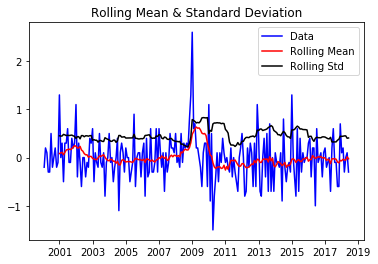

Results of Dickey-Fuller Test:
Test Statistic                  -2.772311
p-value                          0.062339
#Lags Used                      11.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


In [108]:
man_diff.dropna(inplace=True)
test_stationarity(man_diff)

After first order differencing, the data is not stationary. So try taking the 2nd order difference.

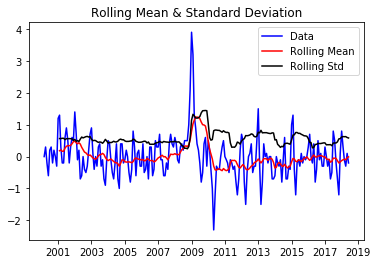

Results of Dickey-Fuller Test:
Test Statistic                  -3.302930
p-value                          0.014748
#Lags Used                      13.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64


In [109]:
man_2nd_diff = df_m.Manufacturing - df_m.Manufacturing.shift(2)
man_2nd_diff.dropna(inplace=True)
test_stationarity(man_2nd_diff)

This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. The P value is less than 0.05 and test statistic is also smaller than the 5% critical values. So we can say with 95% confidence that this is a stationary series. We can go ahead with this.

# Generate and Interpret an autocorrelation function (ACF) and PACF.

In [135]:
x_acf = pd.DataFrame(acf(man_2nd_diff))
x_pacf = pd.DataFrame(pacf(man_2nd_diff))

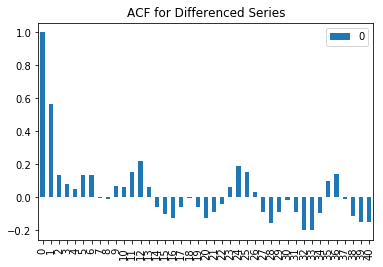

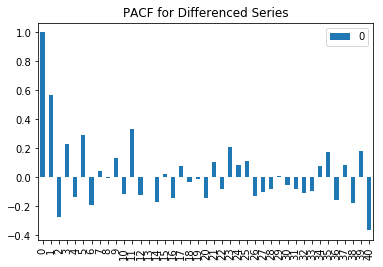

In [136]:
x_acf.plot(kind='bar')
plt.title('ACF for Differenced Series')
plt.show()

x_pacf.plot(kind='bar')
plt.title('PACF for Differenced Series')
plt.show()

The ACF and PACF plot shows the lag1 to be significant with a high autocorelation value.

# AutoRegressive Integrated Moving Average (ARIMA) Model

ARIMA model enables to use linear regression models on non-stationary data.

$AR: Autoregression$: 

A model that uses the relationship between an observation and some number of lagged observations.

$I: Integrated$:

The use of differencing of raw observations in order to make the time series stationary.

$MA: Moving Average$: 

A model that uses the dependency between an observation and past error.    

ARIMA models are denoted with the notation $ARIMA (p, d, q)$. 

p : Number of AR (Auto-Regressive) terms  -  the number of lag observations to include in the model

d : the number of times that the raw observations are differenced, or the degree of differencing. 

q : Number of MA (Moving Average) terms 
    


# Model Preparation
Let's start creating training and testing data. 
Unlike traditional supervised learning models where we randomly split the data, our training and testing data sets needs to remain sequential to preserve time dependency. We will take the last 30 observations as the test data and remaining as training data.

In [149]:
man_train_data = df_m.Manufacturing[:-30].dropna()
man_test_data = df_m.Manufacturing[-30:] 

In [150]:
print('Training Data Length ',len(man_train_data))
print('Test Data Length ',len(man_test_data))

Training Data Length  192
Test Data Length  30


Next we'll build a functions to fit and test various ARIMA configurations to determine the best model for the data. Typically, we'd look to the Akaike information criteria (AIC) to evalute a model, choosing the model configuration with the lowest AIC score. 

In [221]:
warnings.filterwarnings('ignore')
arima_aic_list = []
arima_mse_list = []
arima_param_list = []

# Function to generate predictions for a given arima order
def evaluate_arima(train, test, arima_order):
    
    # Populate history based on training set
    history = [x for x in train]    
    # Create blank list of predictions to populate
    predictions = list()
    
    # Use rolling forward walk predictions.  Fit model using history,
    # adding each prediction to history to continue forecasting
    
    for i in range(len(test)):
        # Fit using history
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        aic_val = model_fit.aic
        # Get prediction
        y_pred = model_fit.forecast()[0]        
        # Append prediction to prediction list to check accuracy 
        predictions.append(y_pred)        
        # Append to history to continue to rolling forecast 
        history.append(y_pred)
    
    error = mean_squared_error(test, predictions)
    
    return error, aic_val

# Function to determine best arima order combination based on lowest MSE
def arima_gridsearch(train, test, p_vals, d_vals, q_vals):
    
    best_score = float('inf') 
    best_config = None
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                arima_order = (p, d, q)
                try:
                    mse, aic_val = evaluate_arima(train, test, arima_order)
                    arima_param_list.append(arima_order)
                    arima_aic_list.append(aic_val)
                    arima_mse_list.append(mse)
                    if mse < best_score:
                        best_score, best_config = mse, arima_order
                    
                except (ValueError, np.linalg.LinAlgError): # ignore non converging errors
                    pass
    
    print('Best ARIMA config:', best_config)
    print('MSE:', best_score)
    return best_score, best_config

In [223]:
# Fit and test RUN ARIMA model- 30 day test period
Arima_best_score , Arima_best_config = arima_gridsearch(man_train_data, man_test_data, range(4), range(3), range(4))

Best ARIMA config: (2, 2, 0)
MSE: 0.18681353951


In [224]:
arima_model_output_df = pd.DataFrame({'AIC' :arima_aic_list ,'MSE': arima_mse_list , 'Param': arima_param_list})


,AIC,MSE,Param
0,988.270081,6.593406,"(0, 0, 0)"
1,765.281997,6.410375,"(0, 0, 1)"


In [227]:
top_arima_model = arima_model_output_df.sort_values(by= 'MSE', ascending=True).head(1)
arima_aic = top_arima_model.AIC.values[0]
print(arima_aic)


334.444876639


In [228]:
arima_model_output_df.sort_values(by= 'AIC', ascending=True).head(1)

,AIC,MSE,Param
25,270.826046,0.382347,"(3, 1, 1)"


In [377]:
arima_best_by_l_aic = arima_model_output_df.sort_values(by= 'AIC', ascending=True).head(1).Param.values[0]
print(arima_best_by_l_aic)

(3, 1, 1)


We'll also build function to examine residuals from the optimized model configuration. Examining the residuals in an ARIMA model is an important step because the model is based on a linear regression and the underlying assumptions of a linear regression. Ideally, we want to see that our error terms are random and normally distributed.

We'll also build function to plot the predictions, to have a look at our predictions.

In [412]:
# Function to evaluate residuals

def plot_residuals(train, p, d, q):
    model = ARIMA(train, order=(p,d,q))
    model_fit = model.fit()
    residuals = model_fit.resid
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('ARIMA Residuals')
    residuals.plot()
    
    plt.subplot(1,2,2)
    residuals.hist()    
    plt.title('ARIMA Residual Histogram')
    plt.show()

# Function to plot predictions
def plot_predictions(train, test, p, d, q):

    arima_order = (p,d,q)    
    history = [x for x in train]        
    predictions = list()
    for i in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        y_pred = model_fit.forecast()[0]    
        predictions.append(y_pred)
        history.append(y_pred)
    
        
    # Plots
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.plot(man_train_data.index, man_train_data, label='Train')
    plt.plot(man_test_data.index, man_test_data, label='Test')
    plt.plot(man_test_data.index, predictions, label='Predictions')
    plt.title('ARIMA Forecast - Full Time Series')
    plt.ylabel('Unemployment Rate')
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.subplot(122)
    plt.autoscale()
    plt.plot(man_train_data.index, man_train_data, label='Train')
    plt.plot(man_test_data.index, man_test_data, label='Test')
    plt.plot(man_test_data.index, predictions, label='Predictions')
    plt.title('ARIMA - Compare forecast for the test period')
    plt.ylabel('Unemployment Rate')
    plt.ylim(min(predictions) - 5, max(predictions) + 5)
    plt.xlim([datetime.date(2016, 1, 1), datetime.date(2018, 6, 1)])
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.tight_layout()

# ARIMA Best Model - Lowest MSE

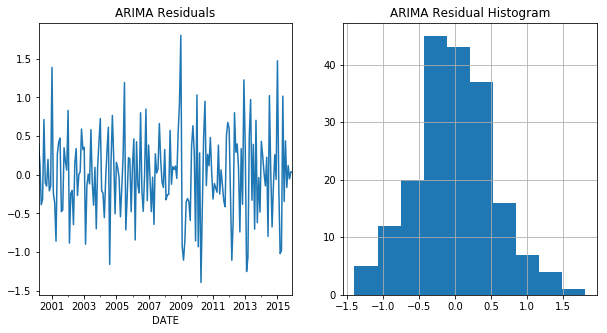

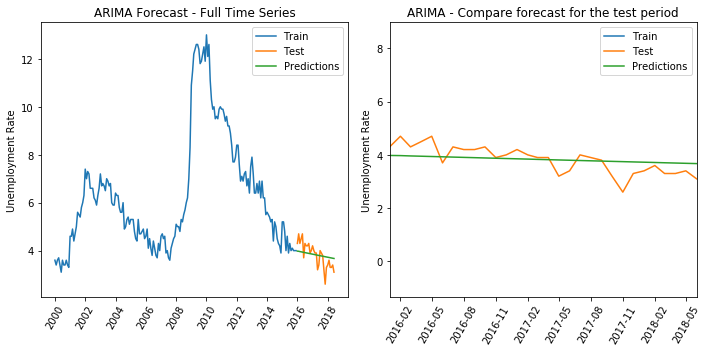

In [414]:
plot_residuals(man_train_data, 2,2,0)
plot_predictions(man_train_data, man_test_data, 2,2,0)

# ARIMA Best Model - Lowest AIC

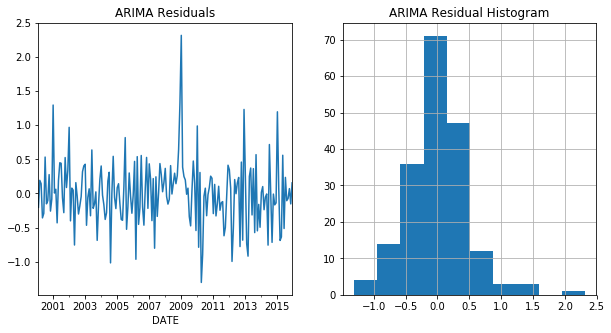

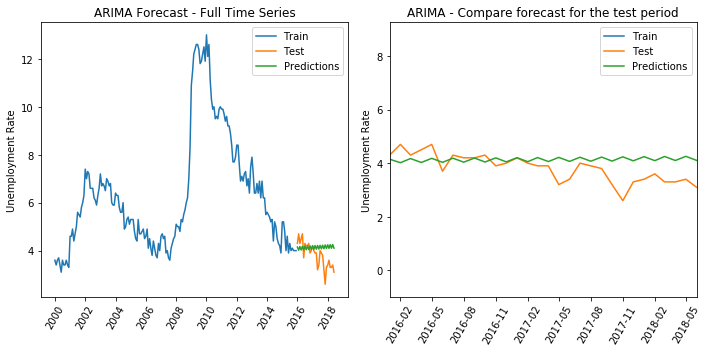

In [415]:
plot_residuals(man_train_data, 3,1,1)
plot_predictions(man_train_data, man_test_data, 3,1,1)

# SARIMAX

$Seasonal$ $AutoRegressive$ $Integrated$ $Moving$ $Average$ $with$ $eXogenous$ $regressors$  $Model$

When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as $ARIMA (p,d,q) \times (P,D,Q)_{s}$. Here, (p,d,q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term $s$ is the seasonal periodicity (4 for quarterly periods, 12 for yearly periods, etc.)

We will first try to remove the seasonality taking seasonal difference and then do adfuller test

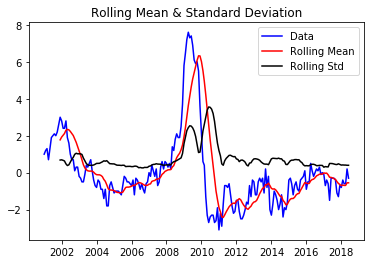

Results of Dickey-Fuller Test:
Test Statistic                  -2.225755
p-value                          0.197031
#Lags Used                      13.000000
Number of Observations Used    196.000000
Critical Value (1%)             -3.464161
Critical Value (5%)             -2.876402
Critical Value (10%)            -2.574692
dtype: float64


In [157]:
man_seasonal_diff = df_m.Manufacturing - df_m.Manufacturing.shift(12)
man_seasonal_diff.dropna(inplace=True)
test_stationarity(man_seasonal_diff)

The high p value confirms that the data is not stationary.

Try taking seasonal difference on the first order difference and then do the adfuller test

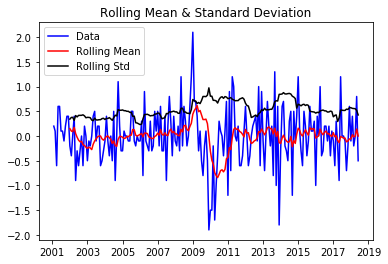

Results of Dickey-Fuller Test:
Test Statistic                -6.231629e+00
p-value                        4.937310e-08
#Lags Used                     1.200000e+01
Number of Observations Used    1.960000e+02
Critical Value (1%)           -3.464161e+00
Critical Value (5%)           -2.876402e+00
Critical Value (10%)          -2.574692e+00
dtype: float64


In [158]:
man_first_diff = df_m.Manufacturing - df_m.Manufacturing.shift()
man_seasonal_first_diff = man_first_diff - man_first_diff.shift(12)
man_seasonal_first_diff.dropna(inplace=True)
test_stationarity(man_seasonal_first_diff)

In [ ]:
This made the data stationary.

# Plot the ACF and PACF of the seasonal differenced data

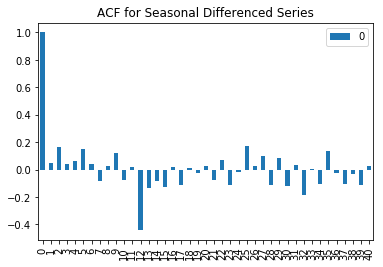

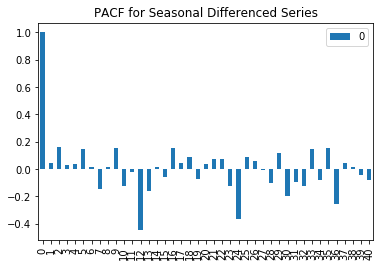

In [160]:
x_acf = pd.DataFrame(acf(man_seasonal_first_diff))
x_pacf = pd.DataFrame(pacf(man_seasonal_first_diff))

x_acf.plot(kind='bar')
plt.title('ACF for Seasonal Differenced Series')
plt.show()

x_pacf.plot(kind='bar')
plt.title('PACF for Seasonal Differenced Series')
plt.show()

Lets split the data into training and testing set.
We will take the last 30 observations as the test data and remaining as training data.

In [165]:
man_seas_train_data = df_m.Manufacturing[:-30].dropna()
man_seas_test_data = df_m.Manufacturing[-30:]

We are generating the combination of values for seasonal and non seasonal parameters.

Using AIC to choose best configuration for SARIMAX Model.

The parameters like 

enforce_stationarity=True - transform the AR parameters to enforce stationarity in the autoregressive component of the model

enforce_invertibility=True - transform the MA parameters to enforce invertibility in the moving average component of the model.

In [369]:
warnings.filterwarnings('ignore') # specify to ignore warning messages
sarima_aic_list = []
sarima_mse_list = []
sarima_ns_param_list = []
sarima_s_param_list = []

# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
print('Range of Non seasonal Parameter \n', pdq)
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Range of Seasonal Parameter \n', seasonal_pdq)

# Function to generate predictions for a given arima order
def evaluate_sarima(train, test, ns_order, s_order):   
    history = [x for x in train]    
    predictions = list() 
    
    for i in range(len(test)):
        model =sarimax.SARIMAX(history,
                                            order=ns_order,
                                            seasonal_order=s_order
                                           , enforce_stationarity=True 
                                           , enforce_invertibility=True
                               )
        model_fit = model.fit()
        aic_val = model_fit.aic
        y_pred = model_fit.forecast()[0]        
        predictions.append(y_pred)        
        history.append(y_pred)     
        

    error = mean_squared_error(test, predictions)
    
    return error, aic_val


# Function to determine best arima order combination based on lowest MSE
def sarima_gridsearch(train, test ):    
    
    sarimax_params = list(itertools.product(pdq, seasonal_pdq))
    start = time.time()
    for i in sarimax_params:        
        try:
            mse, aic_val = evaluate_sarima(train, test, i[0], i[1])
            sarima_ns_param_list.append(tuple(i[0]))
            sarima_s_param_list.append(tuple(i[1]))
            sarima_aic_list.append(aic_val)
            sarima_mse_list.append(mse)    
        
        except (ValueError, np.linalg.LinAlgError): # ignore non converging errors
            pass
    print('SARIMAX Grid Search Completed in {} Seconds'.format(time.time() - start))    


Range of Non seasonal Parameter 
 [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]
Range of Seasonal Parameter 
 [(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12)]


In [370]:
sarima_gridsearch(man_seas_train_data, man_seas_test_data)

SARIMAX Grid Search Completed in 7731.246221780777 Seconds


In [421]:
sarimax_comp_df = pd.DataFrame({'param_Non_seasonal': sarima_ns_param_list ,
                                'param_seasonal': sarima_s_param_list,
                                'AIC': sarima_aic_list,
                                'MSE': sarima_mse_list
                               })


top_sarimax_lowest_aic = sarimax_comp_df.sort_values(by = 'AIC', ascending= True).head(1)

sarimax_aic = top_sarimax_lowest_aic.AIC.values[0]
sarimax_NSP_l_aic = top_sarimax_lowest_aic.param_Non_seasonal.values[0]
sarimax_SP_l_aic  = top_sarimax_lowest_aic.param_seasonal.values[0]

print(top_sarimax_lowest_aic)
print('Lowest AIC', sarimax_aic)
print('Best Configuration',sarimax_NSP_l_aic, sarimax_SP_l_aic)

            AIC       MSE param_Non_seasonal param_seasonal
172  238.105821  0.360357          (2, 1, 1)  (0, 1, 1, 12)
Lowest AIC 238.105821294
Best Configuration (2, 1, 1) (0, 1, 1, 12)


In [422]:
top_sarimax_lowest_mse = sarimax_comp_df.sort_values(by = 'MSE', ascending= True).head(1)
print(top_sarimax_lowest_mse)
sarimax_NSP_l_mse = top_sarimax_lowest_mse.param_Non_seasonal.values[0]
sarimax_SP_l_mse = top_sarimax_lowest_mse.param_seasonal.values[0]

            AIC       MSE param_Non_seasonal param_seasonal
145  272.830664  0.108017          (2, 0, 2)  (1, 0, 0, 12)


In [424]:
# Function to evaluate residuals

def plot_sarima_residuals(train, ns_param, s_param):
    model = sarimax.SARIMAX(train,
                                            order = ns_param,
                                            seasonal_order = s_param
                                           , enforce_stationarity=True 
                                           , enforce_invertibility=True
                               )
    model_fit = model.fit()
    residuals = model_fit.resid
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Seasonal ARIMA Residuals')
    residuals.plot()
    
    plt.subplot(1,2,2)
    residuals.hist()    
    plt.title('Seasonal ARIMA Residual Histogram')
    plt.show()

# Function to plot predictions
def plot_sarima_predictions(train, test, ns_param, s_param):

    history = [x for x in train]    
    predictions = list() 
    
    for i in range(len(test)):
        model =sarimax.SARIMAX(history,
                                            order = ns_param,
                                            seasonal_order = s_param
                                           , enforce_stationarity=True 
                                           , enforce_invertibility=True
                               )
        model_fit = model.fit()
        
        y_pred = model_fit.forecast()[0]        
        predictions.append(y_pred)        
        history.append(y_pred) 
    
        
    # Plots
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, predictions, label='Predictions')
    plt.title('Seasonal ARIMA Forecast - Full Time Series')
    plt.ylabel('Unemployment Rate')
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.subplot(122)
    plt.autoscale()
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, predictions, label='Predictions')
    plt.title('Seasonal ARIMA - Compare forecast for the test period')
    plt.ylabel('Unemployment Rate')
    plt.ylim(min(predictions) - 5, max(predictions) + 5)
    plt.xlim([datetime.date(2016, 1, 1), datetime.date(2018, 6, 1)])
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.tight_layout()

# Seasonal ARIMA Best Model - Lowest AIC

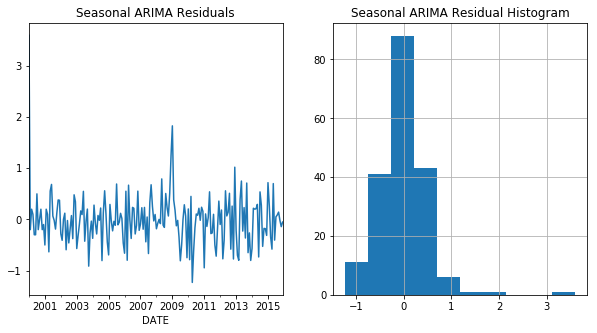

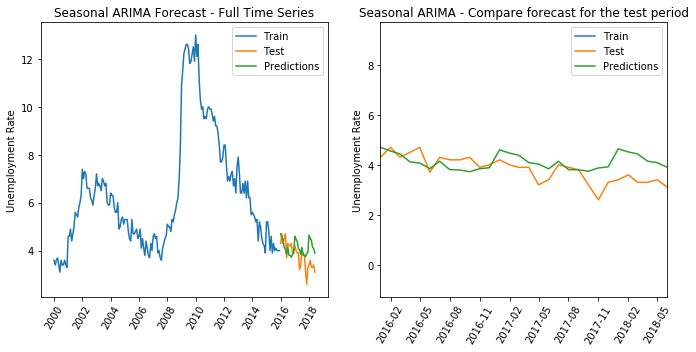

In [425]:
plot_sarima_residuals(man_seas_train_data, sarimax_NSP_l_aic, sarimax_SP_l_aic)
plot_sarima_predictions(man_seas_train_data, man_seas_test_data,sarimax_NSP_l_aic, sarimax_SP_l_aic)

# Seasonal ARIMA Best Model - Lowest MSE

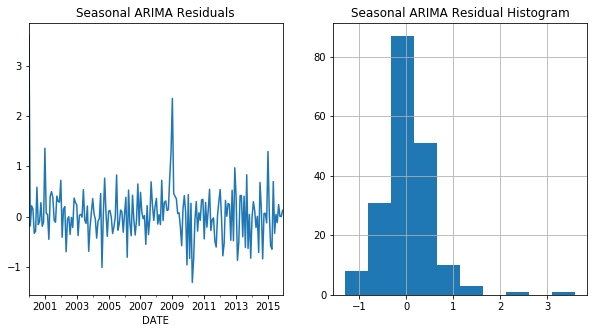

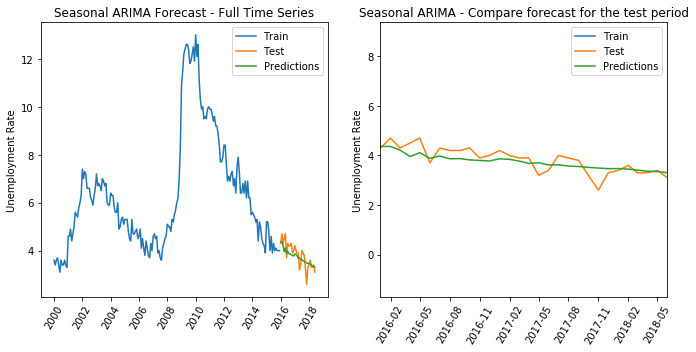

In [426]:
plot_sarima_residuals(man_seas_train_data,sarimax_NSP_l_mse, sarimax_SP_l_mse)
plot_sarima_predictions(man_seas_train_data, man_seas_test_data, sarimax_NSP_l_mse, sarimax_SP_l_mse)

# auto_arima

   auto_arima function allows us to set a range of p,d,q,P,D,and Q values and then fit models for all the possible combinations. Then the model will keep the combination that reported back the best AIC (lowest AIC) value.

   The pyramid-arima library for Python allows us to quickly perform this grid search and even creates a model object that can fit to the training data.

Other Parameters:

  m : The period for seasonal differencing. For example, m is 4 for quarterly data, 12 for monthly data, or 1 for annual (non-seasonal) data. Default is 1. Note that if m == 1 (i.e., is non-seasonal), seasonal will be set to False.
    
  seasonal : Whether to fit a seasonal ARIMA. Default is True. Note that if seasonal is True and m == 1, seasonal will be set to False.
    
   stepwise : The stepwise algorithm can be significantly faster than fitting all (or a random subset of) hyper-parameter combinations and is less likely to over-fit the model.

In [667]:
from pyramid.arima import auto_arima

In [429]:
stepwise_fit = auto_arima(man_seas_train_data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=239.482, BIC=255.418, Fit time=1.212 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=320.645, BIC=327.020, Fit time=0.154 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=287.255, BIC=300.005, Fit time=0.428 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=243.767, BIC=256.516, Fit time=0.919 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=240.557, BIC=259.682, Fit time=1.351 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=318.244, BIC=330.993, Fit time=0.245 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=240.532, BIC=259.656, Fit time=4.621 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=242.846, BIC=265.158, Fit time=2.661 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=237.418, BIC=256.542, Fit time=1.090 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  192
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -112.709
Date:                            Mon, 23 Jul 2018   AIC                            237.418
Time:                                    09:47:24   BIC                            256.542
Sample:                                         0   HQIC                           245.173
                                            - 192                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0022      0.003     -0.834      0.404      -0.007       0.003
ar.L1          0.6186      0.196      3.162      0.002       0.235       1.002
ar.L2          0.1745      0.085      2.056      0.040       0.008       0.341
ma.L1         -0.6381      0.200     -3.190      0.001      -1.030      -0.246
ma.S.L12      -0.9972      2.788     -0.358      0.721      -6.462       4.468
sigma2         0.1719      0.475      0.362      0.717      -0.759       1.102
===================================================================================
Ljung-Box (Q):                       39.49   Jarque-Bera (JB):                17.15
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Evaluation

The AUTO_ARIMA model predicted the same configuration as we saw before when we used SARIMAX.

Now that the model has been fitted to the training data, we can forecast into the future. Recall that our test data set is last 30 observations, means 30 months data. That is the value we will use for our .predict() method call:

In [436]:
auto_arima_y_pred = stepwise_fit.predict(n_periods=30)
auto_arima_mse = mean_squared_error(man_seas_test_data, auto_arima_y_pred)
print(auto_arima_mse) 


1.11586707016


In [587]:
auto_arima_aic = stepwise_fit.aic()
print(auto_arima_aic)
auto_arima_model = 'SARIMAX(2, 1, 1)x(0, 1, 1, 12)'

237.417854319


In [509]:
def plot_auto_arima_residuals():
    
    auto_arima_residuals = pd.DataFrame(stepwise_fit.resid(), index = man_seas_train_data.index, columns = ['Rate'])
       
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(auto_arima_residuals.index, auto_arima_residuals.Rate)
    plt.title('Auto Arima Residuals')
        
    plt.subplot(1,2,2)
    plt.hist(auto_arima_residuals.Rate)
    plt.title('Auto Arima Residual Histogram')
    plt.show()
    
def plot_auto_arima_predictions (predictions):
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.plot(man_seas_train_data.index, man_seas_train_data, label='Train')
    plt.plot(man_seas_test_data.index, man_seas_test_data, label='Test')
    plt.plot(man_seas_test_data.index, predictions, label='Predictions')
    plt.title('Auto Arima Forecast - Full Time Series')
    plt.ylabel('Unemployment Rate')
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.subplot(122)
    plt.autoscale()
    plt.plot(man_seas_train_data.index, man_seas_train_data, label='Train')
    plt.plot(man_seas_test_data.index, man_seas_test_data, label='Test')
    plt.plot(man_seas_test_data.index, predictions, label='Predictions')
    plt.title('Auto Arima - Compare forecast for the test period')
    plt.ylabel('Unemployment Rate')
    plt.ylim(min(predictions) - 5, max(predictions) + 5)
    plt.xlim([datetime.date(2016, 1, 1), datetime.date(2018, 6, 1)])
    plt.xticks(rotation=60)
    plt.legend()
    

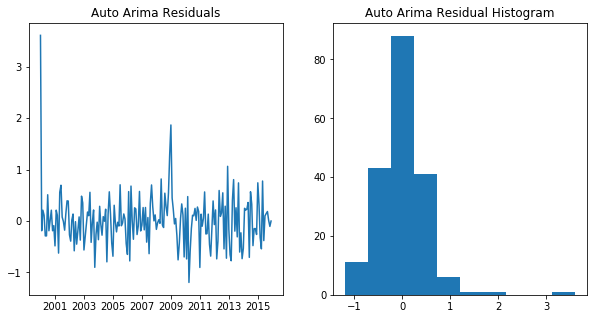

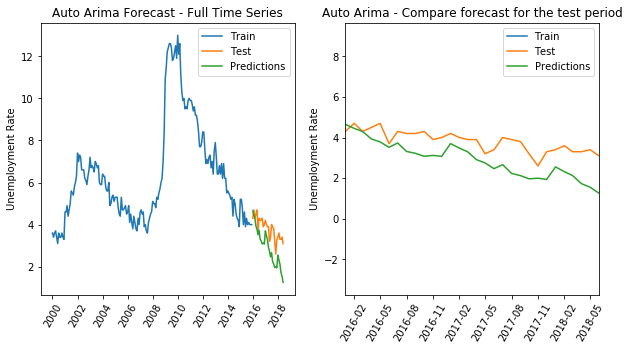

In [511]:
plot_auto_arima_residuals()
plot_auto_arima_predictions(auto_arima_y_pred )

# Facebook Prophet Model

•	Prophet is a package developed by Facebook for forecasting time series data. 

•	It is based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 

•	It works best with time series that have strong seasonal effects and several seasons of historical data. 

•	Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. 

•	Prophet allows to include holidays and other special events.


More information can be found at
https://facebook.github.io/prophet/ and
https://research.fb.com/prophet-forecasting-at-scale/



In [515]:
from fbprophet import Prophet

In [516]:
df_m = pd.read_csv('Unemployment Rate-Manufacturing.csv')

In [517]:
df_m.head(2)

,DATE,LNU04032232
0,2000-01-01,3.6
1,2000-02-01,3.4


In [518]:
df_m.rename(columns= {'LNU04032232':'Manufacturing'}, inplace=True)

In [519]:
df_m.head(2)

,DATE,Manufacturing
0,2000-01-01,3.6
1,2000-02-01,3.4


In [520]:
df_m.dtypes

DATE              object
Manufacturing    float64
dtype: object

In [521]:
df_m['DATE'] = pd.to_datetime(df_m.DATE)

Prophet requires specific input format. Columns names must be lowercase, date column should be named as 'ds', data as 'y'

In [522]:
prophet_df = df_m.rename(columns={'DATE': 'ds', 'Manufacturing': 'y'})
prophet_df.head()

,ds,y
0,2000-01-01,3.6
1,2000-02-01,3.4
2,2000-03-01,3.6
3,2000-04-01,3.7
4,2000-05-01,3.4


Let's split the data into train/test sets. Take last 30 days as test data

In [523]:
df_prophet_train = prophet_df[:-30]
df_prophet_test = prophet_df[-30:]
df_prophet_train.head()

,ds,y
0,2000-01-01,3.6
1,2000-02-01,3.4
2,2000-03-01,3.6
3,2000-04-01,3.7
4,2000-05-01,3.4


Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.

# Make prediction

In [524]:
mfg_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False)


mfg_prophet.fit(df_prophet_train)

forecast = mfg_prophet.predict(df_prophet_test[['ds']])
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')
yhat_test = forecast.yhat.values


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

•	ds: the datestamp of the forecasted value

•	yhat: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)

•	yhat_lower: the lower bound of our forecasts

•	yhat_upper: the upper bound of our forecasts


In [526]:
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,2016-01-01,4.902838,4.902838,4.902838,2.926604,7.711149,0.522974,0.522974,0.522974,0.0,0.0,0.0,0.522974,0.522974,0.522974,5.425812
1,2016-02-01,4.848506,4.848166,4.849282,2.851728,7.539584,0.356589,0.356589,0.356589,0.0,0.0,0.0,0.356589,0.356589,0.356589,5.205095
2,2016-03-01,4.797679,4.796035,4.800161,2.690738,7.302111,0.278007,0.278007,0.278007,0.0,0.0,0.0,0.278007,0.278007,0.278007,5.075687
3,2016-04-01,4.743347,4.739393,4.748730,2.532183,7.125902,0.047963,0.047963,0.047963,0.0,0.0,0.0,0.047963,0.047963,0.047963,4.791310
4,2016-05-01,4.690768,4.682793,4.699634,2.465684,7.138123,0.030017,0.030017,0.030017,0.0,0.0,0.0,0.030017,0.030017,0.030017,4.720785


We can plot the forecast by calling the Prophet.plot method and passing in our forecast dataframe.

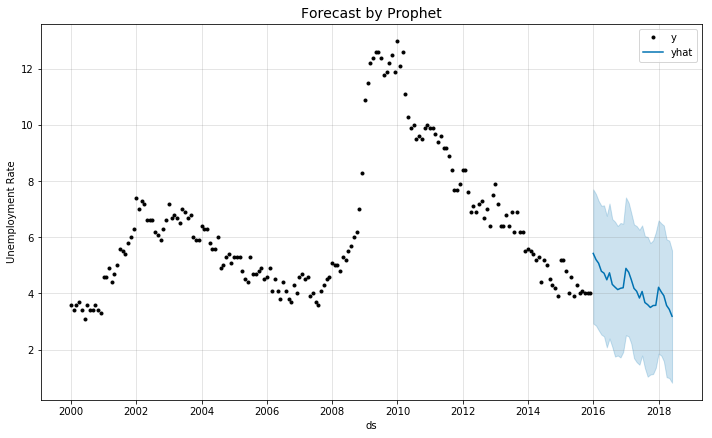

In [533]:
mfg_prophet.plot(forecast, uncertainty=True)
plt.title('Forecast by Prophet', fontsize=14)
plt.legend()
plt.ylabel('Unemployment Rate')
plt.show()

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

In [550]:
def plot_prophet_predictions(prophet_predictions):
    
    print()
    print('\t \t\t \t \t Prophet Model \t\t \t\t \t')
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.plot(df_prophet_train.ds, df_prophet_train.y, label='Train')
    plt.plot(df_prophet_test.ds, df_prophet_test.y, label='Test')
    plt.plot(df_prophet_test.ds, prophet_predictions, label='Predictions')
    plt.title('Forecast - Full Time Series')
    plt.ylabel('Unemployment Rate')
    plt.xticks(rotation=60)
    plt.legend()
       
    plt.subplot(122)
    plt.autoscale()
    plt.plot(df_prophet_train.ds, df_prophet_train.y, label='Train')
    plt.plot(df_prophet_test.ds, df_prophet_test.y, label='Test')
    plt.plot(df_prophet_test.ds, prophet_predictions, label='Predictions')
    plt.fill_between(
    forecast_ci.index.to_pydatetime(),
    forecast_ci['yhat_lower'],
    forecast_ci['yhat_upper'],
    color='b',
    alpha=0.1)
    plt.title('Compare forecast for the test period')
    
    plt.ylim(min(prophet_predictions) - 5, max(prophet_predictions) + 5)
    plt.xlim([datetime.date(2016, 1, 1), datetime.date(2018, 6, 1)])
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.tight_layout()


	 		 	 	 Prophet Model 		 		 	


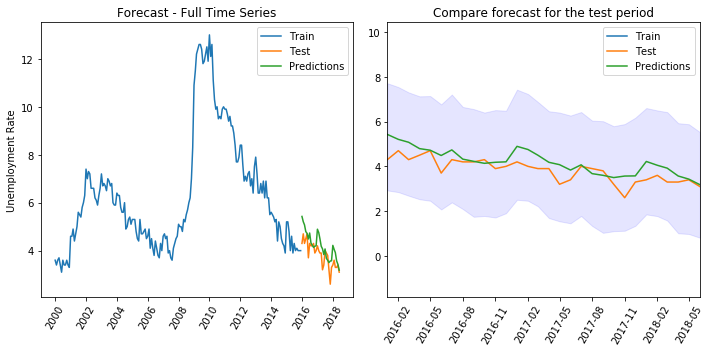

In [551]:
plot_prophet_predictions(yhat_test)

Prophet has created our model and fit the data. It has also (behind the scenes) created some potential changepoints. We can access these changepoints with .changepoints.  By default, Prophet adds 25 changepoints into the initial 80% of the data-set. The number of changepoints can be set by using the n_changepoints parameter when initializing prophet (e.g., model=Prophet(n_changepoints=30).

You can view the changepoints by typing the following:

In [545]:
mfg_prophet.changepoints

6     2000-07-01
12    2001-01-01
18    2001-07-01
24    2002-01-01
30    2002-07-01
36    2003-01-01
43    2003-08-01
49    2004-02-01
55    2004-08-01
61    2005-02-01
67    2005-08-01
73    2006-02-01
79    2006-08-01
85    2007-02-01
91    2007-08-01
97    2008-02-01
103   2008-08-01
109   2009-02-01
116   2009-09-01
122   2010-03-01
128   2010-09-01
134   2011-03-01
140   2011-09-01
146   2012-03-01
152   2012-09-01
Name: ds, dtype: datetime64[ns]

In addition to viewing the dates of the changepoints, we can also view a chart with changepoints added.

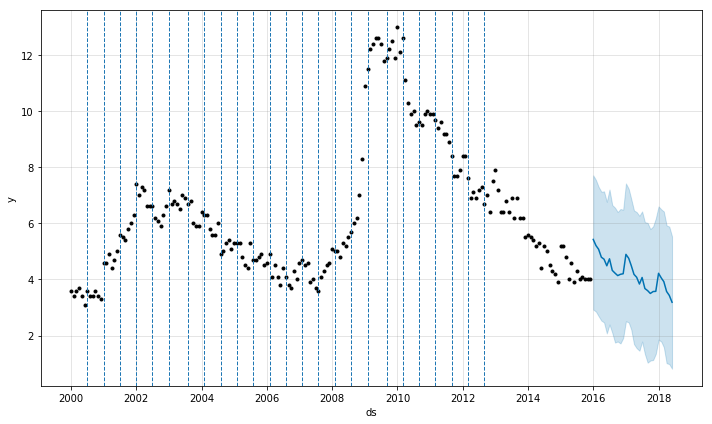

In [547]:
mfg_prophet.plot(forecast, uncertainty=True)
for changepoint in mfg_prophet.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)

We can manually add some changepoints and see the predictions. But when we are not sure about the trend changepoints,  its probably good to keep the defaults that prophet provides.

In [549]:
cp=['2007-12-01', '2008-07-01', '2009-05-01', '2010-01-10', '2011-01-01','2011-06-01','2011-12-01']

mfg_prophet_cp_d = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoints=cp)


mfg_prophet_cp_d.fit(df_prophet_train)

forecast_cpd = mfg_prophet_cp_d.predict(df_prophet_test[['ds']])
forecast_ci_cpd = forecast_cpd[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')
yhat_test_cpd = forecast_cpd.yhat.values




	 		 	 	 Prophet Model 		 		 	


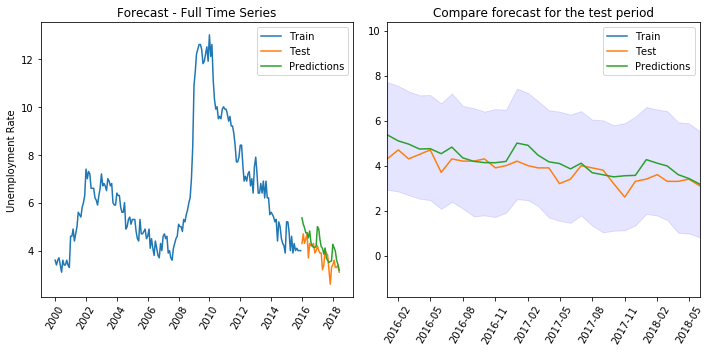

In [552]:
plot_prophet_predictions(yhat_test_cpd)

The parameter " changepoint_prior_scale " adjusts trend flexibility. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible where as Decreasing it will make the trend less flexible. Let's experiment with a range of values and see how the model changes.

ChangePoint 		 MSE
0.01 		 14.0952320415
0.05 		 0.271662327181
1.0 		 2.27850774068
10.0 		 2.54855609363


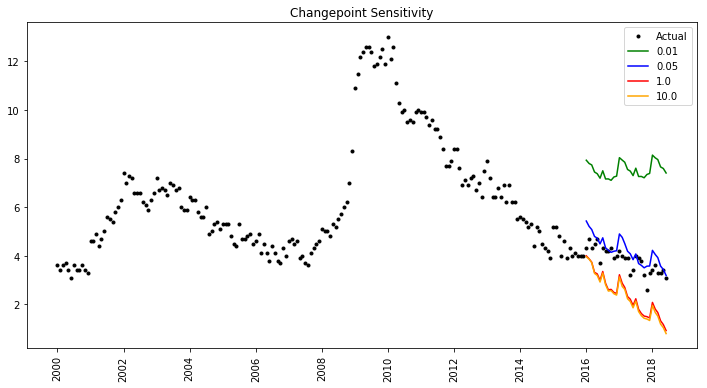

In [544]:
# Evaluate across range of changepoint sensitivity
changepoints = [0.01, 0.05, 1.0, 10.0]
print('ChangePoint \t\t MSE' )
for cp in changepoints:
    mfg_prophet_CP = Prophet(yearly_seasonality=True,
                          weekly_seasonality=False,
                          daily_seasonality=False, 
                          changepoint_prior_scale=cp)
    mfg_prophet_CP.fit(df_prophet_train)
    
    forecast_CP = mfg_prophet_CP.predict(df_prophet_test[['ds']])
    
    
    df_prophet_test[cp] = forecast_CP.yhat.values
    yhat_test_CP = forecast_CP.yhat.values
    
    mse = mean_squared_error(df_prophet_test.y, yhat_test_CP)
    
    print(cp, '\t\t' ,mse)

#Plot results
plt.figure(figsize=(12,6))

# Acual observations
plt.plot(prophet_df['ds'], prophet_df['y'], '.', color='black', label='Actual')
colors = {0.01: 'g', 0.05: 'b', 1.0: 'r', 10.0: 'orange'}
for cp in changepoints:
    plt.plot(df_prophet_test['ds'], df_prophet_test[cp], color=colors[cp], label=cp)

plt.title('Changepoint Sensitivity')
plt.legend()
plt.xticks(rotation=90)
plt.show()

We can see the changepoint setting makes a big difference in the model predictions. Since the Mean Squared Error is least with the default changepoint settings, we will go ahead with the default changepoint.

Prophet also allows the ability to decompose the data into different levels of seasonality/patterns. 

To see the forecast components, we can use the Prophet.plot_components method. Prophet tries to plot the trend, yearly seasonality, and weekly seasonality of the time series if available. If holidays were included, we could see those too.

Since we are working with monthly data, Prophet will plot the trend and the yearly seasonality but if you were working with daily data, you would also see a weekly seasonality plot included.

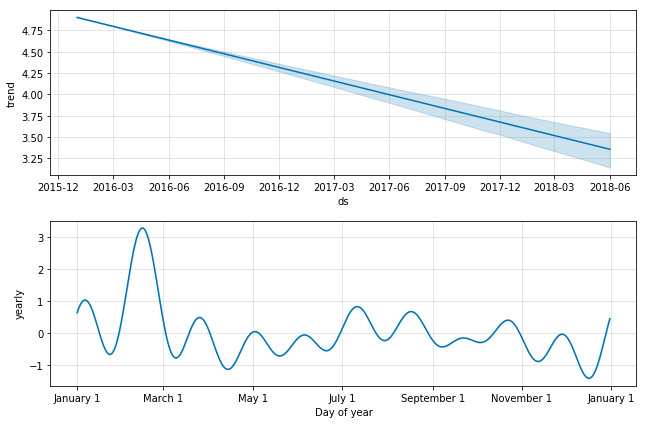

In [553]:
mfg_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False)


mfg_prophet.fit(df_prophet_train)

forecast = mfg_prophet.predict(df_prophet_test[['ds']])
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')
yhat_test = forecast.yhat.values
mfg_prophet.plot_components(forecast)
plt.show()

From the trend and seasonality, we can see that the trend is a playing a large part in the underlying time series and seasonality comes into play more toward the beginning of the year.

In [555]:
# Calculate MSE 

prophet_mse = mean_squared_error(df_prophet_test.y, yhat_test)
print('MSE calculated from Prophet Model: ', prophet_mse)


MSE calculated from Prophet Model:  0.271662327181


# LSTM

LSTM network (Long Short-Term Memory Network) is a recurrent neural network  
trained using Backpropagation Through Time and overcomes the vanishing gradient problem.
We can phrase our time series analysis as a regression analysis. That is, given the unemployment rate this month, what is the unemployment rate next month?

We can write a simple function to convert our single column of data into a multi-column dataset: the first column containing this month’s (t) unemployment rate and the second column containing next month’s (t+1) unemployment rate , to be predicted. or so on.



Before we get started, let’s first import all of the functions and classes we intend to use. 

In [83]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


Lets read the dataset and make it stationary.

In [84]:
df_m = pd.read_csv('Unemployment Rate-Manufacturing.csv')

In [85]:
df_m.rename(columns= {'LNU04032232':'Manufacturing'}, inplace=True)

In [86]:
df_m['DATE'] = pd.to_datetime(df_m.DATE)
df_m_idx = df_m.set_index('DATE')
df_m_idx.head()

,Manufacturing
DATE,
2000-01-01,3.6
2000-02-01,3.4
2000-03-01,3.6
2000-04-01,3.7
2000-05-01,3.4


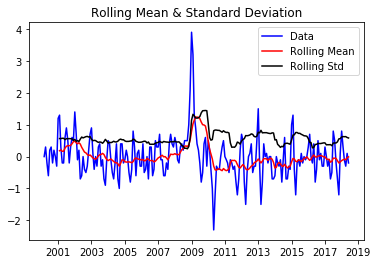

Results of Dickey-Fuller Test:
Test Statistic                  -3.302930
p-value                          0.014748
#Lags Used                      13.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64


In [87]:
man_2nd_diff = df_m_idx.Manufacturing - df_m_idx.Manufacturing.shift(2)
man_2nd_diff.dropna(inplace=True)
test_stationarity(man_2nd_diff)

In [88]:
dataset = pd.DataFrame(man_2nd_diff)

# normalize features - 
LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions 
are used. It can be a good practice to rescale the data . 
We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library

In [89]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [556]:
lstm_train_data = dataset[:-30]
lstm_test_data = dataset[-30:]
print(len(lstm_train_data))
print(len(lstm_test_data))

190
30


Now we can define a function to create new dataset.

The function takes two arguments: 

•  dataset - a NumPy array that we want to convert into a dataset

•  look_back - the number of previous time steps to use as input variables to predict the next time period — defaulted to 1.


In [91]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [558]:
look_back = 1
lstm_trainX, lstm_trainY = create_dataset(lstm_train_data, look_back)
lstm_testX, lstm_testY = create_dataset(lstm_test_data, look_back)
print(lstm_trainX.shape)
print(lstm_trainY.shape)

(188, 1)
(188,)


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].
The first dimension is the length of values, the second is the number of time steps (lags), and the third is the number of predictors .
Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. 
We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [559]:
# reshape input to be [samples, time steps, features]
lstm_trainX = np.reshape(lstm_trainX, (lstm_trainX.shape[0], 1, lstm_trainX.shape[1]))
lstm_testX = np.reshape(lstm_testX, (lstm_testX.shape[0], 1, lstm_testX.shape[1]))
print(lstm_trainX.shape)
print(lstm_trainY.shape)

(188, 1, 1)
(188,)


We are now ready to design and fit our LSTM network for this problem.
The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.


In [561]:
# create and fit the LSTM network
lstm_model = Sequential()
lstm_model.add(LSTM(4, input_shape=(1, look_back)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(lstm_trainX, lstm_trainY, epochs=100, batch_size=1, verbose=2)

C:\Users\gyans\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Epoch 1/100
 - 52s - loss: 0.0875
Epoch 2/100
 - 0s - loss: 0.0198
Epoch 3/100
 - 0s - loss: 0.0151
Epoch 4/100
 - 0s - loss: 0.0142
Epoch 5/100
 - 0s - loss: 0.0146
Epoch 6/100
 - 0s - loss: 0.0141
Epoch 7/100
 - 0s - loss: 0.0133
Epoch 8/100
 - 0s - loss: 0.0136
Epoch 9/100
 - 0s - loss: 0.0123
Epoch 10/100
 - 0s - loss: 0.0116
Epoch 11/100
 - 0s - loss: 0.0118
Epoch 12/100
 - 0s - loss: 0.0128
Epoch 13/100
 - 0s - loss: 0.0122
Epoch 14/100
 - 0s - loss: 0.0120
Epoch 15/100
 - 0s - loss: 0.0122
Epoch 16/100
 - 0s - loss: 0.0113
Epoch 17/100
 - 0s - loss: 0.0110
Epoch 18/100
 - 0s - loss: 0.0114
Epoch 19/100
 - 0s - loss: 0.0112
Epoch 20/100
 - 0s - loss: 0.0105
Epoch 21/100
 - 0s - loss: 0.0109
Epoch 22/100
 - 0s - loss: 0.0099
Epoch 23/100
 - 0s - loss: 0.0106
Epoch 24/100
 - 0s - loss: 0.0108
Epoch 25/100
 - 0s - loss: 0.0102
Epoch 26/100
 - 0s - loss: 0.0096
Epoch 27/100
 - 0s - loss: 0.0100
Epoch 28/100
 - 0s - loss: 0.0102
Epoch 29/100
 - 0s - loss: 0.0101
Epoch 30/100
 - 0s - l

# make predictions

In [562]:

trainPredict = lstm_model.predict(lstm_trainX)
testPredict = lstm_model.predict(lstm_testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
lstm_trainY = scaler.inverse_transform([lstm_trainY])
testPredict = scaler.inverse_transform(testPredict)
lstm_testY = scaler.inverse_transform([lstm_testY])
# calculate root mean squared error
trainScore = mean_squared_error(lstm_trainY[0], trainPredict[:,0])
print('Train Score: %.2f MSE' % (trainScore))
lstm_1_lb_mse = mean_squared_error(lstm_testY[0], testPredict[:,0])
print('Test Score: %.2f MSE' % (lstm_1_lb_mse))

Train Score: 0.31 MSE
Test Score: 0.25 MSE


# Plot the predictions

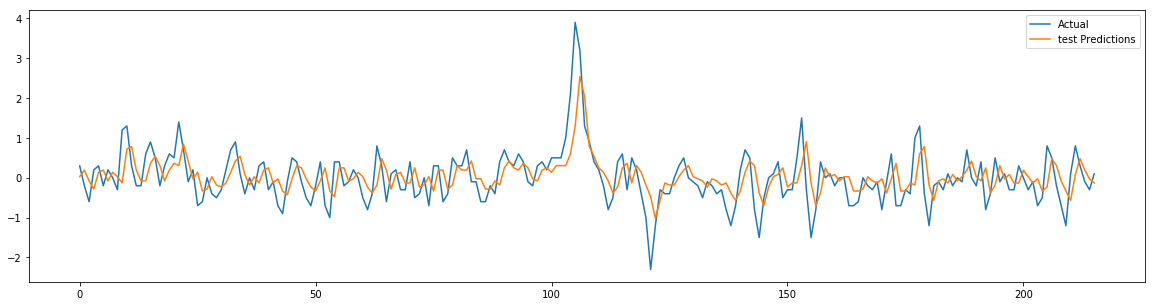

In [563]:
observed_data = list(lstm_trainY[0]) + list(lstm_testY[0])
predicted = list(trainPredict[:,0]) + list (testPredict[:,0])
plt.figure(figsize=(20,5))
plt.plot(observed_data, label = 'Actual')
plt.plot(predicted , label = 'test Predictions')
plt.legend()
plt.show()

We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step.

Let's look back to 24 months of data to predict for next month.

In [582]:
look_back = 24
lstm_trainX_24, lstm_trainY_24 = create_dataset(lstm_train_data, look_back)
lstm_testX_24, lstm_testY_24 = create_dataset(lstm_test_data, look_back)

In [583]:
# reshape input to be [samples, time steps, features]
lstm_trainX_24 = np.reshape(lstm_trainX_24, (lstm_trainX_24.shape[0], 1, lstm_trainX_24.shape[1]))
lstm_testX_24 = np.reshape(lstm_testX_24, (lstm_testX_24.shape[0], 1, lstm_testX_24.shape[1]))
lstm_trainX_24.shape

(165, 1, 24)

In [584]:
# create and fit the LSTM network
lstm_model_24 = Sequential()
lstm_model_24.add(LSTM(4, input_shape=(1, look_back)))
lstm_model_24.add(Dropout(0.2))
lstm_model_24.add(Dense(1))
lstm_model_24.compile(loss='mean_squared_error', optimizer='adam')
lstm_model_24.fit(lstm_trainX_24, lstm_trainY_24, epochs=100, batch_size=1, verbose=2)

C:\Users\gyans\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Epoch 1/100
 - 4s - loss: 0.0539
Epoch 2/100
 - 0s - loss: 0.0276
Epoch 3/100
 - 0s - loss: 0.0209
Epoch 4/100
 - 0s - loss: 0.0200
Epoch 5/100
 - 0s - loss: 0.0185
Epoch 6/100
 - 0s - loss: 0.0161
Epoch 7/100
 - 0s - loss: 0.0160
Epoch 8/100
 - 0s - loss: 0.0162
Epoch 9/100
 - 0s - loss: 0.0152
Epoch 10/100
 - 0s - loss: 0.0151
Epoch 11/100
 - 0s - loss: 0.0144
Epoch 12/100
 - 0s - loss: 0.0137
Epoch 13/100
 - 0s - loss: 0.0142
Epoch 14/100
 - 0s - loss: 0.0142
Epoch 15/100
 - 0s - loss: 0.0131
Epoch 16/100
 - 0s - loss: 0.0124
Epoch 17/100
 - 0s - loss: 0.0126
Epoch 18/100
 - 0s - loss: 0.0119
Epoch 19/100
 - 0s - loss: 0.0123
Epoch 20/100
 - 0s - loss: 0.0112
Epoch 21/100
 - 0s - loss: 0.0115
Epoch 22/100
 - 0s - loss: 0.0124
Epoch 23/100
 - 0s - loss: 0.0108
Epoch 24/100
 - 0s - loss: 0.0110
Epoch 25/100
 - 0s - loss: 0.0103
Epoch 26/100
 - 0s - loss: 0.0111
Epoch 27/100
 - 0s - loss: 0.0108
Epoch 28/100
 - 0s - loss: 0.0116
Epoch 29/100
 - 0s - loss: 0.0099
Epoch 30/100
 - 0s - lo

In [585]:
# make predictions
trainPredict_24 = lstm_model_24.predict(lstm_trainX_24)
testPredict_24 = lstm_model_24.predict(lstm_testX_24)
# invert predictions
trainPredict_24 = scaler.inverse_transform(trainPredict_24)
lstm_trainY_24 = scaler.inverse_transform([lstm_trainY_24])
testPredict_24 = scaler.inverse_transform(testPredict_24)
lstm_testY_24 = scaler.inverse_transform([lstm_testY_24])
# calculate mean squared error
trainScore_24 = mean_squared_error(lstm_trainY_24[0], trainPredict_24[:,0])
print('MSE For Training Data %.2f ' % (trainScore_24))
lstm_24_lb_mse = mean_squared_error(lstm_testY_24[0], testPredict_24[:,0])
print('MSE For Test Data %.2f ' % (lstm_24_lb_mse))

MSE For Training Data 0.23 
MSE For Test Data 0.05 


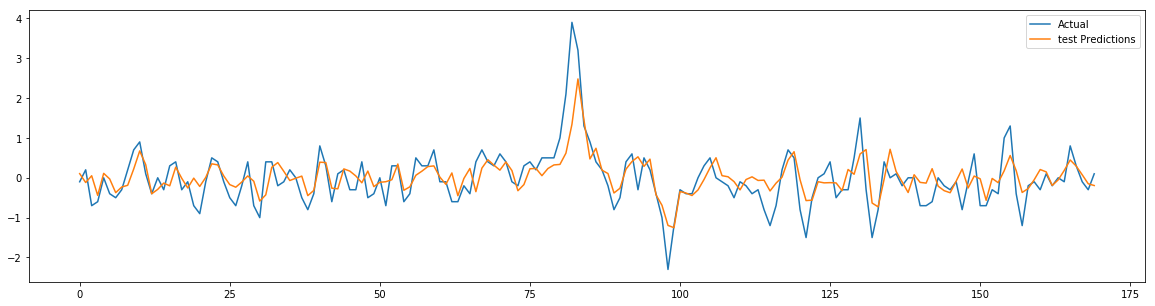

In [586]:
observed_data_24 = list(lstm_trainY_24[0]) + list(lstm_testY_24[0])
predicted_24 = list(trainPredict_24[:,0]) + list (testPredict_24[:,0])
plt.figure(figsize=(20,5))
plt.plot(observed_data_24, label = 'Actual')
plt.plot(predicted_24 , label = 'test Predictions')
plt.legend()
plt.show()

# COMPARE the models


In [593]:
top_arima_mse = arima_model_output_df.sort_values(by= 'AIC', ascending=True).head(1)['MSE'].values[0]
top_arima_aic = arima_model_output_df.sort_values(by= 'AIC', ascending=True).head(1)['AIC'].values[0]
print(top_arima_mse)
print(top_arima_aic)

0.382347115586
270.826045918


In [595]:
top_sarimax_mse = sarimax_comp_df.sort_values(by = 'AIC', ascending= True).head(1)['MSE'].values[0]
top_sarimax_aic = sarimax_comp_df.sort_values(by = 'AIC', ascending= True).head(1)['AIC'].values[0]
print(top_sarimax_mse)
print(top_sarimax_aic)

0.360357376019
238.105821294


In [598]:
model_comp_df = pd.DataFrame({
    'Model' : ['ARIMA', 'SARIMAX', 'AUTO_ARIMA', 'PROPHET', 'LSTM_1_look_back','LSTM_24_look_back' ],
    'AIC_Value' : [top_arima_aic,top_sarimax_aic,auto_arima_aic, np.nan,np.nan,np.nan],
    'Mean_Squared_error' : [top_arima_mse,top_sarimax_mse,auto_arima_mse, prophet_mse, lstm_1_lb_mse, lstm_24_lb_mse]
}, columns = ['Model','AIC_Value','Mean_Squared_error'])
model_comp_df

,Model,AIC_Value,Mean_Squared_error
0,ARIMA,270.826046,0.382347
1,SARIMAX,238.105821,0.360357
2,AUTO_ARIMA,237.417854,1.115867
3,PROPHET,NaN,0.271662
4,LSTM_1_look_back,NaN,0.254277
5,LSTM_24_look_back,NaN,0.052934


To compare between ARIMA, SARIMAX and AUTO ARIMA, we can choose AIC as the metrics and the model with Lowest AIC can be considered as the best model.

In [600]:
model_comp_df.sort_values(by= 'AIC_Value')

,Model,AIC_Value,Mean_Squared_error
2,AUTO_ARIMA,237.417854,1.115867
1,SARIMAX,238.105821,0.360357
0,ARIMA,270.826046,0.382347
3,PROPHET,NaN,0.271662
4,LSTM_1_look_back,NaN,0.254277
5,LSTM_24_look_back,NaN,0.052934


AUTO ARIMA has the lowest AIC value when compared with SARIMAX and ARIMA models.

To compare between all models, we can take MSE as the metrics, since prophet and LSTM models dont record any AIC value.

In [599]:
model_comp_df.sort_values(by= 'Mean_Squared_error')

,Model,AIC_Value,Mean_Squared_error
5,LSTM_24_look_back,NaN,0.052934
4,LSTM_1_look_back,NaN,0.254277
3,PROPHET,NaN,0.271662
1,SARIMAX,238.105821,0.360357
0,ARIMA,270.826046,0.382347
2,AUTO_ARIMA,237.417854,1.115867


The LSTM model with 24 months look back, provided the lowest mean squared error. 

# Conclusion

We looked at a large range of ARIMA configurations as well as a more powerful forecasting tool developed by the Facebook. We also looked at the LSTM Neural Network model. All of the models did farely well. We found that we could decrease LSTM model errors by increasing the amount of historic data included in the model. We can achieve some more improvements in LSTM model . We can try some parameter tuning in LSTM models or adding layers of LSTM blocks etc. 